In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("RentListingInquries_FE_train.csv")
y_train = train['interest_level']
train = train.drop(['interest_level'], axis = 1)
X_train = np.array(train)

In [3]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [4]:
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=None, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 3
        
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =list(cv_folds.split(X_train, y_train)),
                         metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        
        n_estimators = cvresult.shape[0]
        alg.set_params(n_estimators = n_estimators)
        
        print (cvresult)
        #result = pd.DataFrame(cvresult)   #cv缺省返回结果为DataFrame
        #result.to_csv('my_preds.csv', index_label = 'n_estimators')
        cvresult.to_csv('my_preds_6.csv', index_label = 'n_estimators')
        
        # plot
        test_means = cvresult['test-mlogloss-mean']
        test_stds = cvresult['test-mlogloss-std'] 
        
        train_means = cvresult['train-mlogloss-mean']
        train_stds = cvresult['train-mlogloss-std'] 

        x_axis = range(0, n_estimators)
        pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
        pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
        pyplot.title("XGBoost n_estimators vs Log Loss")
        pyplot.xlabel( 'n_estimators' )
        pyplot.ylabel( 'Log Loss' )
        pyplot.savefig( 'n_estimators_6.png' )
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)

        
    #Print model report:
    print ("logloss of train :" )
    print (logloss)

     test-mlogloss-mean  test-mlogloss-std  train-mlogloss-mean  \
0              1.068430           0.000099             1.068221   
1              1.040680           0.000246             1.040207   
2              1.015064           0.000505             1.014395   
3              0.991267           0.000766             0.990384   
4              0.969060           0.000798             0.967924   
5              0.948533           0.000719             0.947198   
6              0.929490           0.000691             0.927939   
7              0.911878           0.000784             0.910042   
8              0.895402           0.000747             0.893337   
9              0.880112           0.000666             0.877818   
10             0.865825           0.000727             0.863297   
11             0.852361           0.000737             0.849573   
12             0.839680           0.000784             0.836681   
13             0.827906           0.000836             0.82466

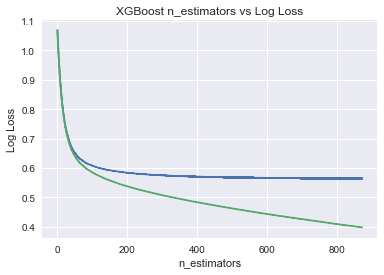

In [13]:
xgb6 = XGBClassifier(
        learning_rate =0.05,
        n_estimators=2000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=5,
        min_child_weight=5,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        reg_alpha = 1.5,
        reg_lambda = 0.5,
        objective= 'multi:softprob',
        seed=3)

modelfit(xgb6, X_train, y_train, cv_folds = kfold)